In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import netCDF4 as nc
import statistics
import datetime
from scipy.spatial import KDTree
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import geopandas as gpd
import dask
import dask.array as da
import xarray as xr
import csv
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
import os

In [2]:
''' Corners of the box of interest '''
location = 0
centers  = [[-153.65, 66.70], # Alatna (2, 3572)
            [-155.69, 66.01], # Huslia (2, 3612)
            [-157.01, 66.96], # (2, 3548)
            [-157.82, 65.81], # (2, 3630)
            [-158.34, 65.23], # (2, 3674)
            [-153.05, 67.12], # (2, 3537)
            [-152.30, 67.12], # (2, 3539)
            [-150.92, 66.71], # (2, 3568)
            [-146.44, 66.96], # (2, 3550) 
            [-153.26, 64.53]] # (2, 3728)

min_lon = centers[location][0] - .65
max_lon = centers[location][0] + .65
min_lat = centers[location][1] - .25
max_lat = centers[location][1] + .25

box_lon = np.array([min_lon, max_lon, max_lon, min_lon, min_lon])
box_lat = np.array([min_lat, min_lat, max_lat, max_lat, min_lat])

print(max(box_lon), min(box_lon), min_lon, max_lon, min_lat, max_lat)

-153.0 -154.3 -154.3 -153.0 66.45 66.95


<IPython.core.display.Javascript object>


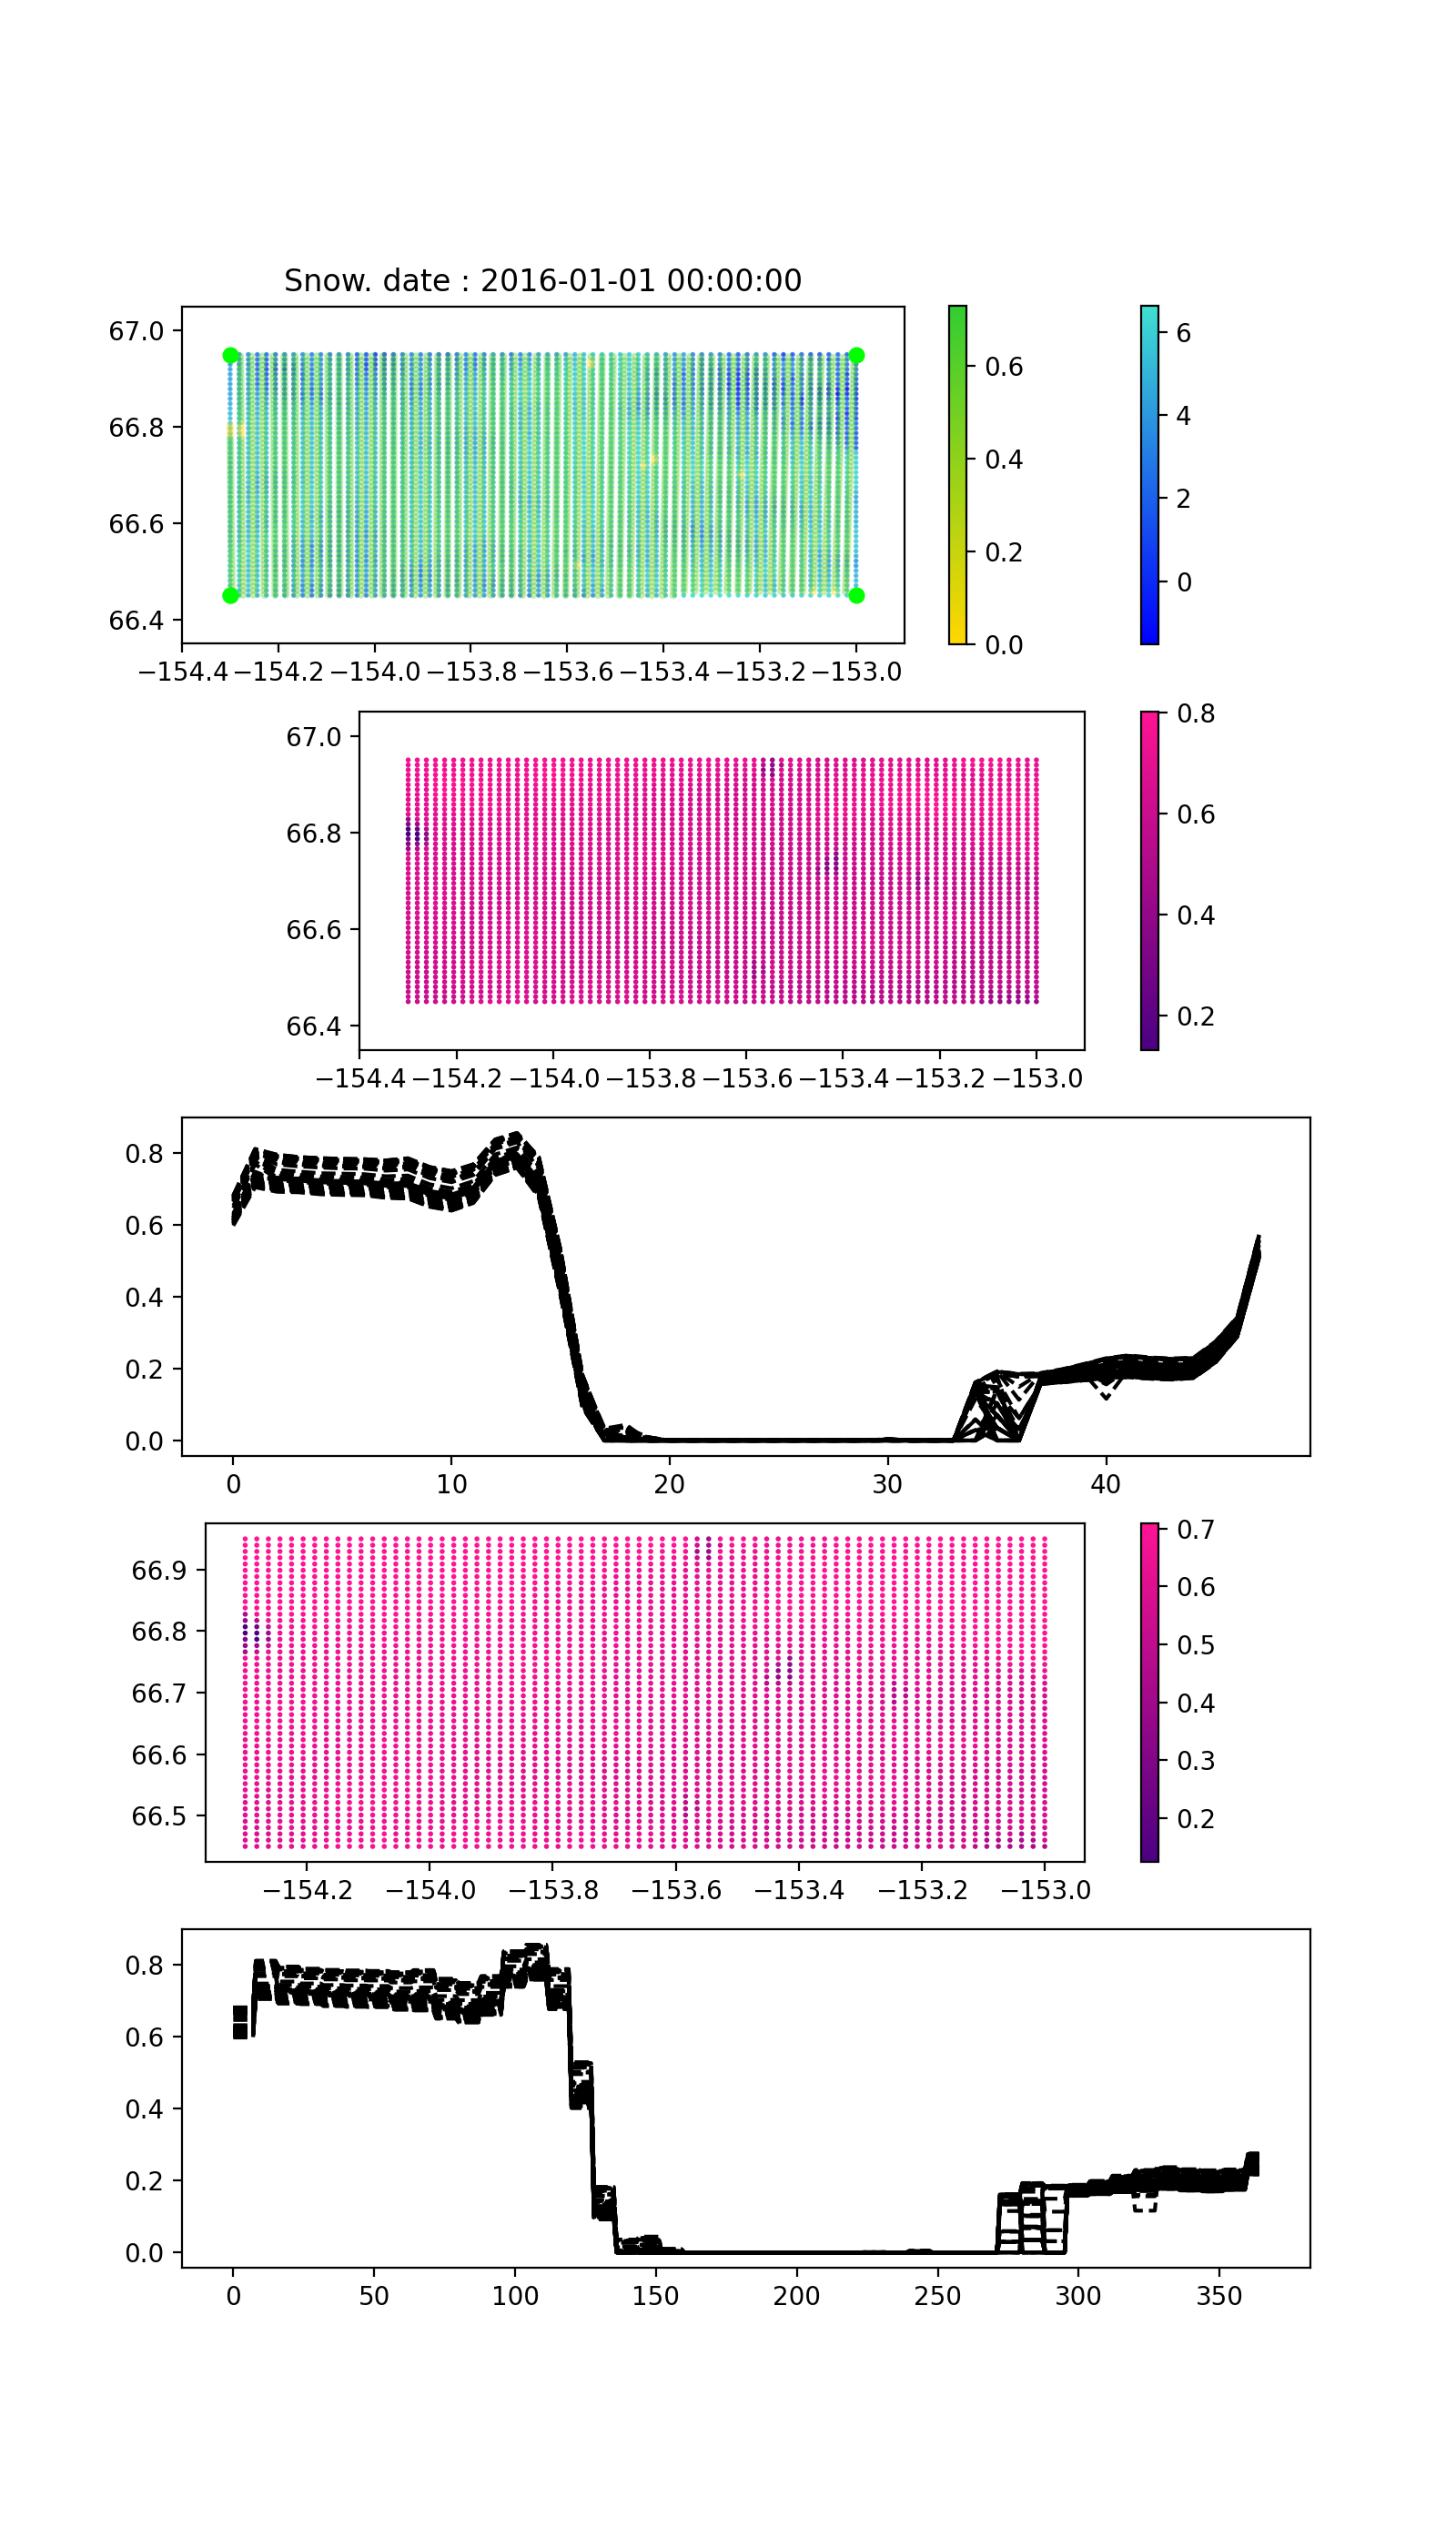

(66.35000000000001, 67.05)

In [3]:
fig, ax  = plt.subplots(5, figsize=(8, 14))

ax[0].set_xlim(min_lon - .1, max_lon + .1)
ax[0].set_ylim(min_lat - .1, max_lat + .1)
ax[1].set_xlim(min_lon - .1, max_lon + .1)
ax[1].set_ylim(min_lat - .1, max_lat + .1)

## Get temp data

In [4]:
tmax_files = ["/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Temp/tmax_2016_1_1-2016_12_31_krig_grid.nc"]

In [5]:
f = nc.Dataset(tmax_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_tmax = f.variables["lat"] # Pointer to variable
lat_tmax = np.array(lat_tmax[:]) # : Extracts the numbers

lon_tmax = f.variables["lon"]
lon_tmax = np.array(lon_tmax[:])

time_tmax = f.variables["time"]
time_tmax = np.array(time_tmax[:])

tmax = f.variables["tmax"]
tmax = np.array(tmax[:])

f.close()

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'tmax'])


In [6]:
print(np.shape(lat_tmax), np.shape(lon_tmax), min(lat_tmax.ravel()), max(lat_tmax.ravel()), min(lon_tmax.ravel()), max(lon_tmax.ravel()), np.shape(tmax))

(70, 50) (70, 50) 66.45 66.95 -154.3 -153.0 (365, 70, 50)


In [7]:
#print(time_tmax)

In [8]:
''' Get points for the temp plot '''
points_tmax = [Point(xy) for xy in zip(lon_tmax.ravel(), lat_tmax.ravel())]
points_tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax)

In [9]:
date = 100

tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=tmax[date, :].ravel())

print(tmax_gdf.head())

                      geometry   data
0  POINT (-154.30000 66.45000)  5.335
1  POINT (-154.30000 66.46021)  5.540
2  POINT (-154.30000 66.47041)  5.540
3  POINT (-154.30000 66.48061)  5.825
4  POINT (-154.30000 66.49081)  5.895


In [10]:
norm_tmax = Normalize(vmin=min(tmax_gdf['data']), vmax=max(tmax_gdf['data']))
cmap_tmax = LinearSegmentedColormap.from_list('custom', ['blue', 'turquoise'], N=200) # Higher N=more smooth

## Get snow data

In [11]:
snow_files = ["/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Snow/snow_Alanta_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Snow/snow_Huslia_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Snow/snow_Loc1_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Snow/snow_Loc2_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Snow/snow_Loc3_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Snow/snow_Loc4_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Snow/snow_Loc5_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Snow/snow_Loc6_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Snow/snow_Loc7_subset_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Snow/snow_Loc8_subset_grid.nc"]

In [12]:
''' Get necessary files '''
f = nc.Dataset(snow_files[location], "r")

# Print the dimensions of the file
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

# Get the data for a variable
lat_snow = f.variables["lat"] # Pointer to variable
lat_snow = np.array(lat_snow[:]) # : Extracts the numbers

lon_snow = f.variables["lon"]
lon_snow = np.array(lon_snow[:])

time_snow = f.variables["time"]
time_snow = np.array(time_snow[:])

snow = f.variables["snow_depth"]
snow = np.array(snow[:])

#print(time_light)
# Close the file
f.close()

dict_keys(['time', 'x'])
dict_keys(['lat', 'lon', 'time', 'snow_depth'])


In [13]:
print(np.shape(lat_snow), np.shape(lon_snow), np.shape(time_snow), min(lat_snow.ravel()), max(lat_snow.ravel()), min(lon_snow.ravel()), max(lon_snow.ravel()), np.shape(snow))

(3216,) (3216,) (48,) 66.45001 66.946266 -154.29996 -153.00371 (48, 3216)


In [14]:
''' Get points for the snow plot and box '''
points_snow = [Point(xy) for xy in zip(lon_snow.ravel(), lat_snow.ravel())]
points_snow_gdf = gpd.GeoDataFrame(geometry=points_snow)

print(points_snow_gdf.head())

                      geometry
0  POINT (-154.29602 66.45091)
1  POINT (-154.27368 66.45095)
2  POINT (-154.25133 66.45098)
3  POINT (-154.22897 66.45102)
4  POINT (-154.20662 66.45104)


In [15]:
''' Make geo dataframe '''
date = 0
print(snow[date, :].ravel(), np.sum(snow, axis=0))

sum_snow = np.sum(snow, axis=0)

snow_gdf = gpd.GeoDataFrame(geometry=points_snow).assign(data=snow[date, :].ravel())

[0.57151735 0.5709069  0.5721045  ... 0.64415747 0.6433948  0.64262164] [12.493009 12.482496 12.526941 ... 15.964844 16.09377  15.131261]


In [16]:
norm_snow = Normalize(vmin=min(snow[date, :].ravel()), vmax=max(snow[date, :].ravel()))
cmap_snow = LinearSegmentedColormap.from_list('custom', ['gold', 'limegreen'], N=200) # Higher N=more smooth

## Plot normal

In [17]:
''' Corners of the box of interest '''
print(max(box_lon), min(box_lon))

points_box = [Point(xy) for xy in zip(box_lon, box_lat)]
points_box_gdf = gpd.GeoDataFrame(geometry=points_box)

-153.0 -154.3


In [18]:
tmax_gdf.plot(ax=ax[0], column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=1, alpha=.75, legend=True)

plt.draw()

In [19]:
snow_gdf.plot(ax=ax[0], column='data', cmap=cmap_snow, norm=norm_snow, markersize=5, alpha=.25, legend=True)

plt.draw()

In [20]:
points_box_gdf.plot(ax=ax[0], color='lime', edgecolor='lime', linewidth=.5, alpha=1)

plt.draw()

## Perform kriging

In [21]:
def DoKrig(x, y, val, x_target, y_target):
    OK = OrdinaryKriging(
                x,
                y,
                val,
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False,
                nlags=10,
                )
    return OK.execute("points", x_target, y_target)

In [22]:
''' Create tree '''
print(np.array([lon_snow, lat_snow]).T.reshape(-1,2))

tree = KDTree(np.array([lon_snow, lat_snow]).T.reshape(-1,2))

[[-154.29602    66.45091 ]
 [-154.27368    66.45095 ]
 [-154.25133    66.45098 ]
 ...
 [-153.04924    66.94357 ]
 [-153.02647    66.94344 ]
 [-153.00371    66.943306]]


In [23]:
print(np.shape(tmax), np.shape(snow), np.shape(lon_tmax), np.shape(lat_tmax))

(365, 70, 50) (48, 3216) (70, 50) (70, 50)


In [24]:
''' Locate the nearest point in tmax to the snow and set all other points to 0 '''
new_snow = np.ones((np.shape(snow)[0], np.shape(tmax)[1], np.shape(tmax)[2]), dtype=float)
print(np.shape(new_snow), np.shape(snow), np.shape(tmax))

num_neighbors = 5

for i in range(np.shape(new_snow)[1]):
    for j in range(np.shape(new_snow)[2]):
        print("-----------------", i, j, "------------------")
        ''' Get closest neighbor(s) to desired point in tmax '''
        point_tmax = np.array([lon_tmax[i][j], lat_tmax[i][j]])

        dis, idx = tree.query(point_tmax, k=num_neighbors)

        lon_krig = lon_snow[idx]
        lat_krig = lat_snow[idx]

        for t in range(np.shape(new_snow)[0]):
            snow_krig = snow[t][idx]

            if not (np.all(snow_krig == snow_krig[0])): # Array elements are different
                #print("point =", point)
                #print("lon_krig =", lon_krig)
                #print("lat_krig =", lat_krig)

                zstar, ss = DoKrig(lon_krig, lat_krig, snow_krig, lon_tmax[i], lat_tmax[i])

                new_snow[t][i][j] = zstar[0]
                #print("SHEEEEEEEESH, snow_krig =", snow_krig, ", new_snow[t][i] =", new_snow[t][i])

            else: # All array elements are the same
                #print(snow_krig[idx[0]])
                if not (-999 <= snow_krig[0] and snow_krig[0] <= 367):
                    #print("AHHHHHHH | snow_krig =", snow_krig, ", new_snow[t][i] =", new_snow[t][i])
                    new_snow[t][i][j] = 0
                else:
                    new_snow[t][i][j] = snow_krig[0]
                    #print("snow_krig =", snow_krig, ", new_snow[t][i] =", new_snow[t][i])


            #print("z =", new_snow[t][i], ", snow =", snow_krig, "i =", i, ", t =", t, ", idx =", idx, ", point =", point, " lon =", lon_krig, ", lat =", lat_krig) 

(48, 70, 50) (48, 3216) (365, 70, 50)
----------------- 0 0 ------------------
----------------- 0 1 ------------------
----------------- 0 2 ------------------
----------------- 0 3 ------------------
----------------- 0 4 ------------------
----------------- 0 5 ------------------
----------------- 0 6 ------------------
----------------- 0 7 ------------------
----------------- 0 8 ------------------
----------------- 0 9 ------------------
----------------- 0 10 ------------------
----------------- 0 11 ------------------
----------------- 0 12 ------------------
----------------- 0 13 ------------------
----------------- 0 14 ------------------
----------------- 0 15 ------------------
----------------- 0 16 ------------------
----------------- 0 17 ------------------
----------------- 0 18 ------------------
----------------- 0 19 ------------------
----------------- 0 20 ------------------
----------------- 0 21 ------------------
----------------- 0 22 ------------------
------

----------------- 3 46 ------------------
----------------- 3 47 ------------------
----------------- 3 48 ------------------
----------------- 3 49 ------------------
----------------- 4 0 ------------------
----------------- 4 1 ------------------
----------------- 4 2 ------------------
----------------- 4 3 ------------------
----------------- 4 4 ------------------
----------------- 4 5 ------------------
----------------- 4 6 ------------------
----------------- 4 7 ------------------
----------------- 4 8 ------------------
----------------- 4 9 ------------------
----------------- 4 10 ------------------
----------------- 4 11 ------------------
----------------- 4 12 ------------------
----------------- 4 13 ------------------
----------------- 4 14 ------------------
----------------- 4 15 ------------------
----------------- 4 16 ------------------
----------------- 4 17 ------------------
----------------- 4 18 ------------------
----------------- 4 19 ------------------
--

----------------- 7 44 ------------------
----------------- 7 45 ------------------
----------------- 7 46 ------------------
----------------- 7 47 ------------------
----------------- 7 48 ------------------
----------------- 7 49 ------------------
----------------- 8 0 ------------------
----------------- 8 1 ------------------
----------------- 8 2 ------------------
----------------- 8 3 ------------------
----------------- 8 4 ------------------
----------------- 8 5 ------------------
----------------- 8 6 ------------------
----------------- 8 7 ------------------
----------------- 8 8 ------------------
----------------- 8 9 ------------------
----------------- 8 10 ------------------
----------------- 8 11 ------------------
----------------- 8 12 ------------------
----------------- 8 13 ------------------
----------------- 8 14 ------------------
----------------- 8 15 ------------------
----------------- 8 16 ------------------
----------------- 8 17 ------------------
--

----------------- 11 38 ------------------
----------------- 11 39 ------------------
----------------- 11 40 ------------------
----------------- 11 41 ------------------
----------------- 11 42 ------------------
----------------- 11 43 ------------------
----------------- 11 44 ------------------
----------------- 11 45 ------------------
----------------- 11 46 ------------------
----------------- 11 47 ------------------
----------------- 11 48 ------------------
----------------- 11 49 ------------------
----------------- 12 0 ------------------
----------------- 12 1 ------------------
----------------- 12 2 ------------------
----------------- 12 3 ------------------
----------------- 12 4 ------------------
----------------- 12 5 ------------------
----------------- 12 6 ------------------
----------------- 12 7 ------------------
----------------- 12 8 ------------------
----------------- 12 9 ------------------
----------------- 12 10 ------------------
----------------- 12 

----------------- 15 34 ------------------
----------------- 15 35 ------------------
----------------- 15 36 ------------------
----------------- 15 37 ------------------
----------------- 15 38 ------------------
----------------- 15 39 ------------------
----------------- 15 40 ------------------
----------------- 15 41 ------------------
----------------- 15 42 ------------------
----------------- 15 43 ------------------
----------------- 15 44 ------------------
----------------- 15 45 ------------------
----------------- 15 46 ------------------
----------------- 15 47 ------------------
----------------- 15 48 ------------------
----------------- 15 49 ------------------
----------------- 16 0 ------------------
----------------- 16 1 ------------------
----------------- 16 2 ------------------
----------------- 16 3 ------------------
----------------- 16 4 ------------------
----------------- 16 5 ------------------
----------------- 16 6 ------------------
----------------- 

----------------- 19 31 ------------------
----------------- 19 32 ------------------
----------------- 19 33 ------------------
----------------- 19 34 ------------------
----------------- 19 35 ------------------
----------------- 19 36 ------------------
----------------- 19 37 ------------------
----------------- 19 38 ------------------
----------------- 19 39 ------------------
----------------- 19 40 ------------------
----------------- 19 41 ------------------
----------------- 19 42 ------------------
----------------- 19 43 ------------------
----------------- 19 44 ------------------
----------------- 19 45 ------------------
----------------- 19 46 ------------------
----------------- 19 47 ------------------
----------------- 19 48 ------------------
----------------- 19 49 ------------------
----------------- 20 0 ------------------
----------------- 20 1 ------------------
----------------- 20 2 ------------------
----------------- 20 3 ------------------
---------------

----------------- 23 24 ------------------
----------------- 23 25 ------------------
----------------- 23 26 ------------------
----------------- 23 27 ------------------
----------------- 23 28 ------------------
----------------- 23 29 ------------------
----------------- 23 30 ------------------
----------------- 23 31 ------------------
----------------- 23 32 ------------------
----------------- 23 33 ------------------
----------------- 23 34 ------------------
----------------- 23 35 ------------------
----------------- 23 36 ------------------
----------------- 23 37 ------------------
----------------- 23 38 ------------------
----------------- 23 39 ------------------
----------------- 23 40 ------------------
----------------- 23 41 ------------------
----------------- 23 42 ------------------
----------------- 23 43 ------------------
----------------- 23 44 ------------------
----------------- 23 45 ------------------
----------------- 23 46 ------------------
-----------

----------------- 27 18 ------------------
----------------- 27 19 ------------------
----------------- 27 20 ------------------
----------------- 27 21 ------------------
----------------- 27 22 ------------------
----------------- 27 23 ------------------
----------------- 27 24 ------------------
----------------- 27 25 ------------------
----------------- 27 26 ------------------
----------------- 27 27 ------------------
----------------- 27 28 ------------------
----------------- 27 29 ------------------
----------------- 27 30 ------------------
----------------- 27 31 ------------------
----------------- 27 32 ------------------
----------------- 27 33 ------------------
----------------- 27 34 ------------------
----------------- 27 35 ------------------
----------------- 27 36 ------------------
----------------- 27 37 ------------------
----------------- 27 38 ------------------
----------------- 27 39 ------------------
----------------- 27 40 ------------------
-----------

----------------- 31 10 ------------------
----------------- 31 11 ------------------
----------------- 31 12 ------------------
----------------- 31 13 ------------------
----------------- 31 14 ------------------
----------------- 31 15 ------------------
----------------- 31 16 ------------------
----------------- 31 17 ------------------
----------------- 31 18 ------------------
----------------- 31 19 ------------------
----------------- 31 20 ------------------
----------------- 31 21 ------------------
----------------- 31 22 ------------------
----------------- 31 23 ------------------
----------------- 31 24 ------------------
----------------- 31 25 ------------------
----------------- 31 26 ------------------
----------------- 31 27 ------------------
----------------- 31 28 ------------------
----------------- 31 29 ------------------
----------------- 31 30 ------------------
----------------- 31 31 ------------------
----------------- 31 32 ------------------
-----------

----------------- 35 5 ------------------
----------------- 35 6 ------------------
----------------- 35 7 ------------------
----------------- 35 8 ------------------
----------------- 35 9 ------------------
----------------- 35 10 ------------------
----------------- 35 11 ------------------
----------------- 35 12 ------------------
----------------- 35 13 ------------------
----------------- 35 14 ------------------
----------------- 35 15 ------------------
----------------- 35 16 ------------------
----------------- 35 17 ------------------
----------------- 35 18 ------------------
----------------- 35 19 ------------------
----------------- 35 20 ------------------
----------------- 35 21 ------------------
----------------- 35 22 ------------------
----------------- 35 23 ------------------
----------------- 35 24 ------------------
----------------- 35 25 ------------------
----------------- 35 26 ------------------
----------------- 35 27 ------------------
----------------

----------------- 38 48 ------------------
----------------- 38 49 ------------------
----------------- 39 0 ------------------
----------------- 39 1 ------------------
----------------- 39 2 ------------------
----------------- 39 3 ------------------
----------------- 39 4 ------------------
----------------- 39 5 ------------------
----------------- 39 6 ------------------
----------------- 39 7 ------------------
----------------- 39 8 ------------------
----------------- 39 9 ------------------
----------------- 39 10 ------------------
----------------- 39 11 ------------------
----------------- 39 12 ------------------
----------------- 39 13 ------------------
----------------- 39 14 ------------------
----------------- 39 15 ------------------
----------------- 39 16 ------------------
----------------- 39 17 ------------------
----------------- 39 18 ------------------
----------------- 39 19 ------------------
----------------- 39 20 ------------------
----------------- 39 

----------------- 42 41 ------------------
----------------- 42 42 ------------------
----------------- 42 43 ------------------
----------------- 42 44 ------------------
----------------- 42 45 ------------------
----------------- 42 46 ------------------
----------------- 42 47 ------------------
----------------- 42 48 ------------------
----------------- 42 49 ------------------
----------------- 43 0 ------------------
----------------- 43 1 ------------------
----------------- 43 2 ------------------
----------------- 43 3 ------------------
----------------- 43 4 ------------------
----------------- 43 5 ------------------
----------------- 43 6 ------------------
----------------- 43 7 ------------------
----------------- 43 8 ------------------
----------------- 43 9 ------------------
----------------- 43 10 ------------------
----------------- 43 11 ------------------
----------------- 43 12 ------------------
----------------- 43 13 ------------------
----------------- 43 

----------------- 46 36 ------------------
----------------- 46 37 ------------------
----------------- 46 38 ------------------
----------------- 46 39 ------------------
----------------- 46 40 ------------------
----------------- 46 41 ------------------
----------------- 46 42 ------------------
----------------- 46 43 ------------------
----------------- 46 44 ------------------
----------------- 46 45 ------------------
----------------- 46 46 ------------------
----------------- 46 47 ------------------
----------------- 46 48 ------------------
----------------- 46 49 ------------------
----------------- 47 0 ------------------
----------------- 47 1 ------------------
----------------- 47 2 ------------------
----------------- 47 3 ------------------
----------------- 47 4 ------------------
----------------- 47 5 ------------------
----------------- 47 6 ------------------
----------------- 47 7 ------------------
----------------- 47 8 ------------------
----------------- 47

----------------- 50 33 ------------------
----------------- 50 34 ------------------
----------------- 50 35 ------------------
----------------- 50 36 ------------------
----------------- 50 37 ------------------
----------------- 50 38 ------------------
----------------- 50 39 ------------------
----------------- 50 40 ------------------
----------------- 50 41 ------------------
----------------- 50 42 ------------------
----------------- 50 43 ------------------
----------------- 50 44 ------------------
----------------- 50 45 ------------------
----------------- 50 46 ------------------
----------------- 50 47 ------------------
----------------- 50 48 ------------------
----------------- 50 49 ------------------
----------------- 51 0 ------------------
----------------- 51 1 ------------------
----------------- 51 2 ------------------
----------------- 51 3 ------------------
----------------- 51 4 ------------------
----------------- 51 5 ------------------
-----------------

----------------- 54 25 ------------------
----------------- 54 26 ------------------
----------------- 54 27 ------------------
----------------- 54 28 ------------------
----------------- 54 29 ------------------
----------------- 54 30 ------------------
----------------- 54 31 ------------------
----------------- 54 32 ------------------
----------------- 54 33 ------------------
----------------- 54 34 ------------------
----------------- 54 35 ------------------
----------------- 54 36 ------------------
----------------- 54 37 ------------------
----------------- 54 38 ------------------
----------------- 54 39 ------------------
----------------- 54 40 ------------------
----------------- 54 41 ------------------
----------------- 54 42 ------------------
----------------- 54 43 ------------------
----------------- 54 44 ------------------
----------------- 54 45 ------------------
----------------- 54 46 ------------------
----------------- 54 47 ------------------
-----------

----------------- 58 22 ------------------
----------------- 58 23 ------------------
----------------- 58 24 ------------------
----------------- 58 25 ------------------
----------------- 58 26 ------------------
----------------- 58 27 ------------------
----------------- 58 28 ------------------
----------------- 58 29 ------------------
----------------- 58 30 ------------------
----------------- 58 31 ------------------
----------------- 58 32 ------------------
----------------- 58 33 ------------------
----------------- 58 34 ------------------
----------------- 58 35 ------------------
----------------- 58 36 ------------------
----------------- 58 37 ------------------
----------------- 58 38 ------------------
----------------- 58 39 ------------------
----------------- 58 40 ------------------
----------------- 58 41 ------------------
----------------- 58 42 ------------------
----------------- 58 43 ------------------
----------------- 58 44 ------------------
-----------

----------------- 62 16 ------------------
----------------- 62 17 ------------------
----------------- 62 18 ------------------
----------------- 62 19 ------------------
----------------- 62 20 ------------------
----------------- 62 21 ------------------
----------------- 62 22 ------------------
----------------- 62 23 ------------------
----------------- 62 24 ------------------
----------------- 62 25 ------------------
----------------- 62 26 ------------------
----------------- 62 27 ------------------
----------------- 62 28 ------------------
----------------- 62 29 ------------------
----------------- 62 30 ------------------
----------------- 62 31 ------------------
----------------- 62 32 ------------------
----------------- 62 33 ------------------
----------------- 62 34 ------------------
----------------- 62 35 ------------------
----------------- 62 36 ------------------
----------------- 62 37 ------------------
----------------- 62 38 ------------------
-----------

----------------- 66 13 ------------------
----------------- 66 14 ------------------
----------------- 66 15 ------------------
----------------- 66 16 ------------------
----------------- 66 17 ------------------
----------------- 66 18 ------------------
----------------- 66 19 ------------------
----------------- 66 20 ------------------
----------------- 66 21 ------------------
----------------- 66 22 ------------------
----------------- 66 23 ------------------
----------------- 66 24 ------------------
----------------- 66 25 ------------------
----------------- 66 26 ------------------
----------------- 66 27 ------------------
----------------- 66 28 ------------------
----------------- 66 29 ------------------
----------------- 66 30 ------------------
----------------- 66 31 ------------------
----------------- 66 32 ------------------
----------------- 66 33 ------------------
----------------- 66 34 ------------------
----------------- 66 35 ------------------
-----------

In [25]:
print(np.shape(new_snow))

(48, 70, 50)


In [26]:
''' Test plot of new points '''
snow_kriged_files = ['/Users/joshuamiller/Documents/SULI 2023/Data/Alatna_Box/Snow/snow_Alatna_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Huslia_Box/Snow/snow_Huslia_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Snow/snow_Loc1_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Snow/snow_Loc2_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Snow/snow_Loc3_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Snow/snow_Loc4_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Snow/snow_Loc5_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Snow/snow_Loc6_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Snow/snow_Loc7_2016_1_1-2016_12_31_krig_grid.nc',
                     '/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Snow/snow_Loc8_krig_2016_1_1-2016_12_31_grid.nc']

In [27]:
#ncfile.close()
ncfile = nc.Dataset(snow_kriged_files[location], 'w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('time', new_snow.shape[0])
ncfile.createDimension('x', new_snow.shape[1])
ncfile.createDimension('y', new_snow.shape[2])

# Create variables
lat_var = ncfile.createVariable('lat', 'f4', ('x','y'))
lon_var = ncfile.createVariable('lon', 'f4', ('x','y'))
time_var = ncfile.createVariable('time', 'i4', ('time',)) # Orig. i4
snow_var = ncfile.createVariable('snow', 'f4', ('time','x', 'y'))

lat_var.setncattr('dimensions', 'x' 'y')
lon_var.setncattr('dimensions', 'x' 'y')
time_var.setncattr('dimensions', 'time')
snow_var.setncattr('dimensions', 'time' 'x' 'y')

# Assign values to variables
lat_var[:] = lat_tmax
lon_var[:] = lon_tmax
time_var[:] = time_snow
snow_var[:] = new_snow

# Add variable attributes
lat_var.units = 'degrees north'
lon_var.units = 'degrees east'
time_var.units = 'date'
snow_var.units = 'm'

# Close the file
ncfile.close()

## Extract data for plotting

In [28]:
f = nc.Dataset(snow_kriged_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_snow_krig = f.variables["lat"] # Pointer to variable
lat_snow_krig = np.array(lat_snow_krig[:]) # : Extracts the numbers

lon_snow_krig = f.variables["lon"]
lon_snow_krig = np.array(lon_snow_krig[:])

time_snow_krig = f.variables["time"]
time_snow_krig = np.array(time_snow_krig[:])

snow_krig = f.variables["snow"]
snow_krig = np.array(snow_krig[:])

f.close()

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'snow'])


In [29]:
print(np.shape(lat_snow_krig), np.shape(lon_snow_krig), min(lat_snow_krig.ravel()), max(lat_snow_krig.ravel()), min(lon_snow_krig.ravel()), max(lon_snow_krig.ravel()), np.shape(snow_krig))

print(snow_krig[0, :])
print("-------------")
print(snow_krig[1, :])

(70, 50) (70, 50) 66.45 66.95 -154.3 -153.0 (48, 70, 50)
[[0.5697547  0.569266   0.570196   ... 0.6850754  0.6850754  0.68578035]
 [0.56959736 0.5683275  0.5688749  ... 0.6850754  0.68558365 0.686072  ]
 [0.5709012  0.5701503  0.57278085 ... 0.6850272  0.6859541  0.6859541 ]
 ...
 [0.4143198  0.4143198  0.41965538 ... 0.6415947  0.64277303 0.64277303]
 [0.4146822  0.4199334  0.5146913  ... 0.64097106 0.6421535  0.6421535 ]
 [0.41818783 0.5251083  0.5251083  ... 0.64489067 0.6413567  0.6419966 ]]
-------------
[[0.6669484  0.6662405  0.6674568  ... 0.8148042  0.8148042  0.81574416]
 [0.666777   0.6650845  0.66574395 ... 0.8148042  0.81548965 0.8161488 ]
 [0.66865546 0.66763973 0.67106956 ... 0.81485075 0.81602347 0.81602347]
 ...
 [0.4840376  0.4840376  0.4907996  ... 0.76176935 0.76324147 0.76324147]
 [0.48447275 0.49090704 0.6009651  ... 0.76093316 0.7624104  0.7624104 ]
 [0.48889276 0.6140932  0.6140932  ... 0.75996596 0.76138526 0.76219994]]


In [30]:
#for variable_name in f.variables.keys():
#    variable = f.variables[variable_name]
#    print(f"{variable_name} units: {variable.units}")

In [31]:
date = 10
print(np.shape(snow_krig), snow_krig[date, :].ravel(), np.sum(snow_krig, axis=0))

sum_snow_krig = np.sum(snow_krig, axis=0)

snow_kriged_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=snow_krig[date, :].ravel())

(48, 70, 50) [0.601442   0.60044616 0.60171235 ... 0.7151329  0.72144276 0.7209335 ] [[12.407108 12.384536 12.41136  ... 15.67273  15.67273  15.803787]
 [12.421485 12.362285 12.373231 ... 15.67273  15.797804 15.892807]
 [12.467797 12.448832 12.508089 ... 15.90708  15.896301 15.896301]
 ...
 [ 9.137017  9.137017  9.273092 ... 15.36902  15.679705 15.679705]
 [ 9.143319  9.289867 11.394265 ... 15.126944 15.363315 15.363315]
 [ 9.252043 11.661574 11.661574 ... 15.290998 15.405503 15.443996]]


In [32]:
norm_snow_krig = Normalize(vmin=min(snow_krig[date, :].ravel()), vmax=max(snow_krig[date, :].ravel()))
cmap_snow_krig = LinearSegmentedColormap.from_list('custom', ['indigo', 'deeppink'], N=200) # Higher N=more smooth

In [33]:
#tmax_gdf.plot(ax=ax[1], column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=5, alpha=.05, legend=True)

#plt.draw()

In [34]:
snow_kriged_gdf.plot(ax=ax[1], column='data', cmap=cmap_snow_krig, norm=norm_snow_krig, markersize=1, alpha=1, legend=True) 

plt.draw()

In [35]:
print(np.shape(lat_tmax), np.shape(lon_tmax), np.shape(snow_krig))

(70, 50) (70, 50) (48, 70, 50)


In [36]:
ax[2].plot(np.arange(0, np.shape(snow_krig)[0]), snow_krig[:, 10], 'k--')

plt.draw()

## Convert to everyday instead of every eight days and select snow in date range

In [37]:
start_date = datetime(2016, 1, 1)
num_days = 365

In [38]:
#f.close()
#ncfile.close()
ncfile = nc.Dataset(snow_kriged_files[location], 'w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('time', None)
ncfile.createDimension('x', snow_krig.shape[1])
ncfile.createDimension('y', snow_krig.shape[2])

# Create variables
lat_var = ncfile.createVariable('lat', 'f4', ('x','y'))
lon_var = ncfile.createVariable('lon', 'f4', ('x','y'))
time_var = ncfile.createVariable('time', 'i4', ('time',)) # Orig. i4
snow_var = ncfile.createVariable('snow', 'f4', ('time','x','y'))

lat_var.setncattr('dimensions', 'x' 'y')
lon_var.setncattr('dimensions', 'x' 'y')
time_var.setncattr('dimensions', 'time')
snow_var.setncattr('dimensions', 'time' 'x' 'y')

# Assign values to variables
lat_var[:] = lat_tmax
lon_var[:] = lon_tmax
#=======================================================================================
''' Copy snow values 8 times '''
for t in range(snow_krig.shape[0]): # Number of time measurements in OG dataset
    #print("snow_krig[", t, ", :] =", snow_krig[t, :])
    for j in range(8): # Number of days inbetween measures in OG dataset
        curr_date = start_date + timedelta(days=8 * t + j)
        delta = (curr_date - start_date).days
        
        if (0 <= delta and delta < num_days):
            print("delta =", delta, ", curr_date =", curr_date, ", t =", t, ", j =", j)
            time_var[delta]    = delta # 0, 1, 2, ...
            snow_var[delta, :] = snow_krig[t, :]
#=======================================================================================
# Add variable attributes
lat_var.units = 'degrees north'
lon_var.units = 'degrees east'
time_var.units = 'Days since ' + str(start_date)
snow_var.units = 'm'

# Close the file
ncfile.close()

delta = 0 , curr_date = 2016-01-01 00:00:00 , t = 0 , j = 0
delta = 1 , curr_date = 2016-01-02 00:00:00 , t = 0 , j = 1
delta = 2 , curr_date = 2016-01-03 00:00:00 , t = 0 , j = 2
delta = 3 , curr_date = 2016-01-04 00:00:00 , t = 0 , j = 3
delta = 4 , curr_date = 2016-01-05 00:00:00 , t = 0 , j = 4
delta = 5 , curr_date = 2016-01-06 00:00:00 , t = 0 , j = 5
delta = 6 , curr_date = 2016-01-07 00:00:00 , t = 0 , j = 6
delta = 7 , curr_date = 2016-01-08 00:00:00 , t = 0 , j = 7
delta = 8 , curr_date = 2016-01-09 00:00:00 , t = 1 , j = 0
delta = 9 , curr_date = 2016-01-10 00:00:00 , t = 1 , j = 1
delta = 10 , curr_date = 2016-01-11 00:00:00 , t = 1 , j = 2
delta = 11 , curr_date = 2016-01-12 00:00:00 , t = 1 , j = 3
delta = 12 , curr_date = 2016-01-13 00:00:00 , t = 1 , j = 4
delta = 13 , curr_date = 2016-01-14 00:00:00 , t = 1 , j = 5
delta = 14 , curr_date = 2016-01-15 00:00:00 , t = 1 , j = 6
delta = 15 , curr_date = 2016-01-16 00:00:00 , t = 1 , j = 7
delta = 16 , curr_date = 2016-01-1

delta = 260 , curr_date = 2016-09-17 00:00:00 , t = 32 , j = 4
delta = 261 , curr_date = 2016-09-18 00:00:00 , t = 32 , j = 5
delta = 262 , curr_date = 2016-09-19 00:00:00 , t = 32 , j = 6
delta = 263 , curr_date = 2016-09-20 00:00:00 , t = 32 , j = 7
delta = 264 , curr_date = 2016-09-21 00:00:00 , t = 33 , j = 0
delta = 265 , curr_date = 2016-09-22 00:00:00 , t = 33 , j = 1
delta = 266 , curr_date = 2016-09-23 00:00:00 , t = 33 , j = 2
delta = 267 , curr_date = 2016-09-24 00:00:00 , t = 33 , j = 3
delta = 268 , curr_date = 2016-09-25 00:00:00 , t = 33 , j = 4
delta = 269 , curr_date = 2016-09-26 00:00:00 , t = 33 , j = 5
delta = 270 , curr_date = 2016-09-27 00:00:00 , t = 33 , j = 6
delta = 271 , curr_date = 2016-09-28 00:00:00 , t = 33 , j = 7
delta = 272 , curr_date = 2016-09-29 00:00:00 , t = 34 , j = 0
delta = 273 , curr_date = 2016-09-30 00:00:00 , t = 34 , j = 1
delta = 274 , curr_date = 2016-10-01 00:00:00 , t = 34 , j = 2
delta = 275 , curr_date = 2016-10-02 00:00:00 , t = 34 

In [39]:
#ncfile.close()
f = nc.Dataset(snow_kriged_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_snow_krig2 = f.variables["lat"] # Pointer to variable
lat_snow_krig2 = np.array(lat_snow_krig2[:]) # : Extracts the numbers

lon_snow_krig2 = f.variables["lon"]
lon_snow_krig2 = np.array(lon_snow_krig2[:])

time_snow_krig2 = f.variables["time"]
time_snow_krig2 = np.array(time_snow_krig2[:])

snow_krig2 = f.variables["snow"]
snow_krig2 = np.array(snow_krig2[:])

f.close()

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'snow'])


In [40]:
print(np.shape(time_snow_krig2), np.shape(snow_krig2))

(365,) (365, 70, 50)


In [41]:
#for variable_name in f.variables.keys():
#    variable = f.variables[variable_name]
#    print(f"{variable_name} units: {variable.units}")
    
print(np.shape(time_snow_krig2), np.shape(snow_krig2))

(365,) (365, 70, 50)


In [42]:
''' Get points for the snow plot and box '''
points_snow_krig2 = [Point(xy) for xy in zip(lon_snow_krig2.ravel(), lat_snow_krig2.ravel())]
points_snow_krig2_gdf = gpd.GeoDataFrame(geometry=points_snow_krig2)

print(points_snow_krig2_gdf.head())

                      geometry
0  POINT (-154.30000 66.45000)
1  POINT (-154.30000 66.46021)
2  POINT (-154.30000 66.47041)
3  POINT (-154.30000 66.48061)
4  POINT (-154.30000 66.49081)


In [43]:
date = 0

snow_krig2_gdf = gpd.GeoDataFrame(geometry=points_snow_krig2).assign(data=snow_krig2[date, :].ravel())

In [44]:
norm_snow_krig2 = Normalize(vmin=min(snow_krig2[date, :].ravel()), vmax=max(snow_krig2[date, :].ravel()))
cmap_snow_krig2 = LinearSegmentedColormap.from_list('custom', ['indigo', 'deeppink'], N=200) # Higher N=more smooth

In [45]:
snow_kriged_gdf.plot(ax=ax[3], column='data', cmap=cmap_snow_krig2, norm=norm_snow_krig2, markersize=1, alpha=1, legend=True) 

plt.draw()

In [46]:
ax[4].plot(np.arange(0, np.shape(snow_krig2)[0]), snow_krig2[:, 10], 'k--')

plt.draw()

In [47]:
end_date = datetime(2016, 1, 1) + timedelta(days=date)
ax[0].set_title("Snow. date : " + str(end_date))

Text(0.5, 1.0, 'Snow. date : 2016-01-01 00:00:00')